In [ ]:
# inspired from the work :
# https://www.kaggle.com/miguelniblock/predict-the-author-unsupervised-nlp-lsa-and-bow/data

In [2]:
# General-purpose Libraries
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import spacy
from time import time
%matplotlib inline

# Tools for processing data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, make_scorer, adjusted_rand_score, silhouette_score, homogeneity_score, normalized_mutual_info_score
# Classifiers, supervised and unsupervised
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

import warnings
warnings.filterwarnings("ignore")

In [11]:
# Read data into a DataFrame
data = pd.read_csv('data/articles2.csv')
data.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,53293,73471,Patriots Day Is Best When It Digs Past the Her...,Atlantic,David Sims,2017-01-11,2017.0,1.0,NaN,"Patriots Day, Peter Berg’s new thriller that r..."
1,53294,73472,A Break in the Search for the Origin of Comple...,Atlantic,Ed Yong,2017-01-11,2017.0,1.0,NaN,"In Norse mythology, humans and our world were ..."
2,53295,73474,Obama’s Ingenious Mention of Atticus Finch,Atlantic,Spencer Kornhaber,2017-01-11,2017.0,1.0,NaN,“If our democracy is to work in this increasin...
3,53296,73475,"Donald Trump Meets, and Assails, the Press",Atlantic,David A. Graham,2017-01-11,2017.0,1.0,NaN,Updated on January 11 at 5:05 p. m. In his fir...
4,53297,73476,Trump: ’I Think’ Hacking Was Russian,Atlantic,Kaveh Waddell,2017-01-11,2017.0,1.0,NaN,Updated at 12:25 p. m. After months of equivoc...


In [12]:
print (data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 10 columns):
Unnamed: 0     49999 non-null int64
id             49999 non-null int64
title          49998 non-null object
publication    49999 non-null object
author         41401 non-null object
date           47373 non-null object
year           47373 non-null float64
month          47373 non-null float64
url            42988 non-null object
content        49999 non-null object
dtypes: float64(2), int64(2), object(6)
memory usage: 3.8+ MB
None


### Basic Data Statistics :

- **49999** total entries in the dataset (articles2.csv)
- columns that are complete i.e. which do not have any missing data are : id, title, publication and content
- rest other columns have some missing values : author name, date of publication, url etc.

### Summary :
- **Content, title and publication** columsn are complete. These are the data points needed for further downstream tasks of clustering and classification.

### Length of Articles

- In terms of number of **words**, the average article has around **750 words**.

Statistical Summary of Article Lengths
count    49999.000000
mean       742.464149
std        898.129554
min          2.000000
25%        307.000000
50%        565.000000
75%        886.000000
max      29718.000000
dtype: float64


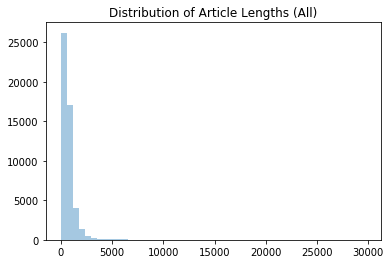

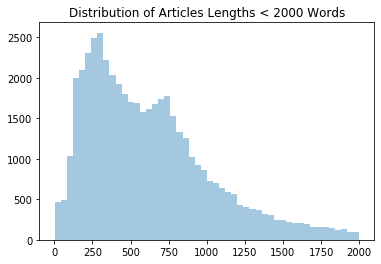

In [21]:
lengths = pd.Series([len(x.split(" ")) for x in data.content])
print('Statistical Summary of Article Lengths')
print(lengths.describe())

sns.distplot(lengths,kde=False)
plt.title('Distribution of Article Lengths (All)')
plt.show()
sns.distplot(lengths[lengths<2000],kde=False)
plt.title('Distribution of Articles Lengths < 2000 Words')
plt.show()

### data distribution:
- distribution based on publisher

- on an average a publisher published 7,142 articles

- we can see, New York Post is highest with 17493 articles (more than double the average), followed by Atlantic 7008 articles just near the average count and National Reviewwith 6203 articles, a little less than average.

- the publications thus can be said to be skewed with high contributions from New York Post.  


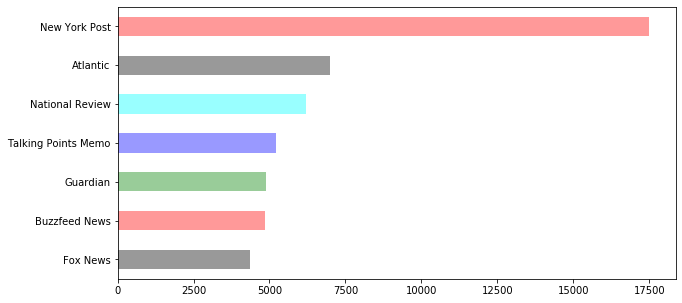

In [25]:
data.publication.value_counts().sort_values().plot(kind = 'barh', figsize=(10,5),alpha = 0.4, color=['black', 'red', 'green', 'blue', 'cyan'])

In [26]:
data.publication.value_counts()

New York Post          17493
Atlantic                7008
National Review         6203
Talking Points Memo     5214
Guardian                4873
Buzzfeed News           4854
Fox News                4354
Name: publication, dtype: int64

In [33]:
data.publication.value_counts().describe()

count        7.000000
mean      7142.714286
std       4653.248103
min       4354.000000
25%       4863.500000
50%       5214.000000
75%       6605.500000
max      17493.000000
Name: publication, dtype: float64